# Final Project - Fake News Detection
## DTSA 5510 Unsupervised Algorithms in Machine Learning
For this final project I will be conducting an Unsupervised Learning classification on a dataset obtained from Kaggle.  This notebook will include the problem description, EDA procedure, analysis (model building and training), result, and discussion/conclusion. 

The problem I have chosen is in classifying new articles as either Real or Fake based on the content of the article.

From: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

Social media is a vast pool of content, and among all the content available for users to access, news is an element that is accessed most frequently. These news can be posted by politicians, news channels, newspaper websites, or even common civilians. These posts have to be checked for their authenticity, since spreading misinformation has been a real concern in today’s times, and many firms are taking steps to make the common people aware of the consequences of spread misinformation. The measure of authenticity of the news posted online cannot be definitively measured, since the manual classification of news is tedious and time-consuming, and is also subject to bias.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from time import time

## Dataset and EDA

Let's read it in and see what we have

In [153]:
fake = pd.read_csv('Fake.csv')
fake.info()

true = pd.read_csv('True.csv')
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [154]:
true.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


First step is that we'll add a label column and combine into a single set fro unsupervised training.

In [155]:
fake['Label'] = 0
true['Label'] = 1

train =  pd.concat([fake, true])

# Randomize the rows
train = train.sample(frac=1).reset_index(drop=True)

I'm not sure what the subject means, but we'll drop the date and subject and combine the title and text into a single field

In [157]:
train['Combined_Text'] = train['title'] + ' ' + train['text']
train = train.drop(['title', 'text', 'subject', 'date'], axis = 1)


,Label,Combined_Text
0,1,The frequent-flyer U.S. Congress: lawmakers wo...
1,1,Inquiry ordered into deadly Indian power plant...
2,0,WATCH: Insider Reveals How Trump University S...


In [163]:
# first 1000 characters of an article
train['Combined_Text'][0][:1000]

'The frequent-flyer U.S. Congress: lawmakers work less in DC WASHINGTON (Reuters) - Anyone seeking a table at Carmine’s Italian restaurant near Capitol Hill on a Tuesday or Wednesday needs to battle a mid-week crush of Congress members and their staff. But Mondays are far quieter — just like the floor of Congress. There are usually around nine events on a Monday, compared to as many as 30 on a midweek day, says Kelly Fitzgerald, Carmine’s director of special events and catering.\xa0 The mid-week crunch at Carmine’s underscores a trend: members of the U.S. Congress have been spending fewer days working in Washington since the late 2000s, according to a Reuters review of congressional records going back 18 years. Lawmakers increasingly try to cram their legislative work into the middle of the week in Washington and then rush back home. Their absence from the capital reinforces the effects of a deepening partisan divide in recent years that has led to high-profile deadlocks over legislati

There are punctuation and other non-word characters.  Let's clean it so that the article is a list of tokenized words.  This is a process called "stemming".  

We also want to remove "stop words" which are common words that do not provide useful information about the content of the text (such as "a", "the", "is").  I would use Natural Language Toolkit (nltk) for this, but it's not available. So instead I grabbed a reasonable manual stopwords list from here: https://gist.github.com/sebleier/554280.  Not ideal, but better than nothing.

In [169]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
             "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", 
             "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
             "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", 
             "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", 
             "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", 
             "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
             "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", 
             "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", 
             "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [224]:
import re

def clean_text(df, col):
    
    # this function will add a column to the dataframe called "clean_text"
    
    clean_text = df[col]
    
    #remove all punctuation
    clean_text = clean_text.apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    #remove numbers 
    clean_text = clean_text.apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #force to lower case
    clean_text = clean_text.apply(lambda x: x.lower())
    
    #remove stop words
    clean_text = clean_text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    
    #remove extra spaces
    df['Clean_Text'] = clean_text.apply(lambda x: re.sub(' +', ' ', x))
    
    return 

In [225]:
clean_text(train,'Combined_Text')

In [226]:
# first 1000 characters of an article after cleaning
train['Clean_Text'][0][:1000]

'frequentflyer us congress lawmakers work less dc washington reuters anyone seeking table carmines italian restaurant near capitol hill tuesday wednesday needs battle midweek crush congress members staff mondays far quieter like floor congress usually around nine events monday compared many midweek day says kelly fitzgerald carmines director special events catering midweek crunch carmines underscores trend members us congress spending fewer days working washington since late according reuters review congressional records going back years lawmakers increasingly try cram legislative work middle week washington rush back home absence capital reinforces effects deepening partisan divide recent years led highprofile deadlocks legislation previously seen routine according former lawmakers political analysts pressure spend time home constituencies often fundraising campaigns members less time attend debates mingle lawmakers work setting dont know colleagues makes much difficult get things don

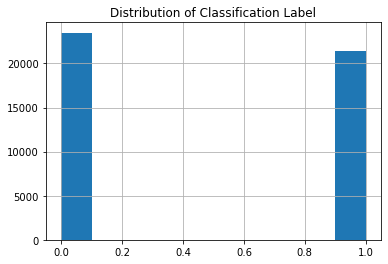

In [227]:
plt.figure()
train['Label'].hist()
plt.title('Distribution of Classification Label')
plt.show()

## Model and data prep

Given that this is a binary classification problem, the first thought that comes to mind is k-means clustering. So we'll try that first.  For most models, we need to convert the text into arrays of numeric numbers that the models can use. For that we will use TF-IDF (Text Frequency, Inverse Document Frequency).

TfidfVectorizer uses an in-memory vocabulary (a Python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.

We set the vectorizer parameters to ignore terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5).  The input data has already had the stop words removed, but i shouldn't hurt to use the internal stop word list as well.

In [229]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    max_features=2000,
    stop_words="english",
)

t0 = time()
X_tfidf = vectorizer.fit_transform(train['Clean_Text'])

print(f"article text vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")


article text vectorization done in 10.147 s
n_samples: 44898, n_features: 2000


Now we will use these vectorized matrices to train a k-mean classifier.

K-means optimizes a non-convex objective function, therefore its clustering is not guaranteed to be optimal for a given random init. Even further, on sparse high-dimensional data such as text vectorized using the Bag of Words approach, k-means can initialize centroids on extremely isolated data points. Those data points can stay their own centroids all along.

In [233]:
print(f"Percent occupancy of Text feature matrix: {100.0 * X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

Percent occupancy of Text feature matrix: 4.460


We can see that the input train matrices are quiet sparse at only a few percent occupancy. 

In [234]:
from sklearn.cluster import KMeans

kmeans_title = KMeans(
    n_clusters=2,
    max_iter=10,
    n_init=3
).fit(X_tfidf)

kmeans_pred = kmeans_title.labels_

K-Means doesn't know the concept of the labels.  It just clusters the data into two (in our case) groups.  We'll use the actual labels to permute the predicted labels and get the best permutation for accuracy analysis.

In [235]:
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

def label_permute_compare(yt,yp):
    labels = np.unique(yt)
    perms = itertools.permutations(labels, len(labels))
    best = 0
    best_perm = []
    for perm in perms:
        y = np.array([perm[label] for label in yp])
        acc = np.mean(y == yt)
        if acc > best:
            best = acc
            best_perm = list(perm)
    return best_perm, best

Accuracy of K-means clustering on Article Text classification:  65.0 %


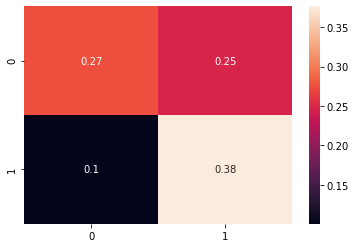

In [236]:
label_order_text, text_acc = label_permute_compare(train['Label'].values,kmeans_pred)
kmeans_pred_labels = np.array([label_order_text[label] for label in kmeans_pred])

print('Accuracy of K-means clustering on Article Text classification: ', int(text_acc*1000)/10,'%')

text_cm = confusion_matrix(train['Label'].values,kmeans_pred_labels)/len(kmeans_pred_labels)
sn.heatmap(text_cm, annot=True)
plt.show()

Well that didn't work very well. It clustered the majority of the data into one cluster and did hardly any better than guess.

Maybe the problem is that there are too many words.

### Model #2, Non-Negative Matrix Factorization

Non-Negative Matrix Factorization (NMF) is a linear algebra algorithm that factorizes a high-dimensional vector, such as a term-document matrix, into a lower-dimensional representation, with only one constraint: the decomposed matrices consist of only non-negative values.

In [237]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2,
          random_state=100,
          init='nndsvda', 
          solver = 'mu',
          beta_loss = 'kullback-leibler')
nmf.fit(X_tfidf)

NMF(alpha=0.0, beta_loss='kullback-leibler', init='nndsvda', l1_ratio=0.0,
    max_iter=200, n_components=2, random_state=100, shuffle=False, solver='mu',
    tol=0.0001, verbose=0)

Accuracy of NMF clustering on Article Text classification:  82.9 %


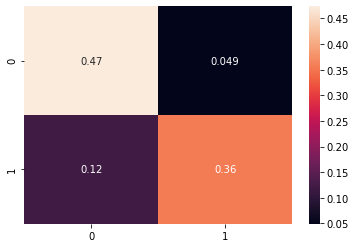

In [238]:
x= nmf.transform(X_tfidf)
nmf_pred = 1*(x[:,0]>x[:,1])

label_order_text, text_acc = label_permute_compare(train['Label'].values,nmf_pred)
text_pred_labels = np.array([label_order_text[label] for label in nmf_pred])

print('Accuracy of NMF clustering on Article Text classification: ', int(text_acc*1000)/10,'%')

text_cm = confusion_matrix(train['Label'].values,text_pred_labels)/len(text_pred_labels)
sn.heatmap(text_cm, annot=True)
plt.show()

NMF performed a lot better but still not very good.

## Compare to Supervised Learning (Random Forest Classifier)

Let's train an RFC on the Article Text data with different ratios of test/train split and see how it does.

In [239]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

test_train_ratio = np.linspace(0.1, 0.9, 9)

test_accuracy = []
cms = []

for x in test_train_ratio:
    
    X_train, X_test, Y_train, Y_test = train_test_split(train['Clean_Text'],train['Label'], test_size = x, random_state = 60,shuffle=True)
    
    rfc = Pipeline([('tfidf', vectorizer),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

    rfc.fit(X_train, Y_train)

    test_predict = rfc.predict(X_test)

    test_accuracy.append(accuracy_score(test_predict, Y_test)*100)
    
    cms.append( [x,confusion_matrix(Y_test,test_predict)/len(test_predict)])

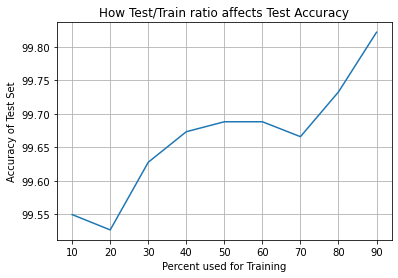

In [240]:
plt.figure()
plt.grid()
plt.plot(100-test_train_ratio*100,test_accuracy)
plt.title('How Test/Train ratio affects Test Accuracy')
plt.xlabel('Percent used for Training')
plt.ylabel('Accuracy of Test Set')
plt.show()

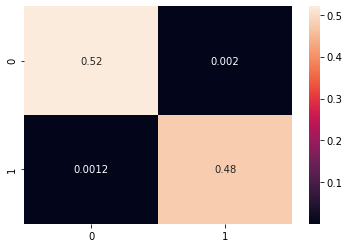

In [242]:
sn.heatmap(cms[5][1], annot=True)
plt.show()


Random Forest Classification did extremely well on these data, even when very little of the data is used to training.

## Conclusion

On the same same of vectorized, cleaned input text data, we performed 3 types of classification.  Two unsupervised and one supervised. 

K-means performed poorly probably due to the fact that text data is often high-dimensional and sparse, which means that the feature space can be very large and most of the features are zero. K-means relies on calculating distances between data points in this high-dimensional space to assign points to clusters. However, in high-dimensional spaces, the distance between any two points tends to be similar, which can make it difficult for K-means to accurately cluster the data. 

Non-negative Matrix Factorization perform better than K-means, but still not very well.  NMF relies on non-negativity constraints, which can result in overly sparse representations that may not capture the full semantic meaning of the text. This can result in poor performance when using NMF for text classification.

Random Forest, a form of supervised classification, performed exceptionally, even when very little of the data was used for training.  

For the most part I beleive that text classification is a problem that requires domain knowledge to properly classify.  Unsupervised learning techniques have trouble with the semantics of subtle changes in meaning and will have difficulty discerning difference in clusters.  Supervised techniques will propably always do better as the labeled data produced with this domain knowledge will greatly aid finding correct differential information between the categories.